# Copyright Netherlands eScience Center <br>
** Function     : Lead/lag regression of climate patterns on atmospheric meridional energy transport (MERRA2,ERA-Interim,JRA55) review only** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.04.06 ** <br>
** Last Update  : 2019.04.06 ** <br>
Description     : <br>

Return Value    : NetCFD4 data file<br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib, logging<br>
variables       : Meridional Energy Transport E [Tera-Watt] <br>
Caveat!!        : Spatial and temporal coverage<br>
                  Atmosphere<br>
                  ERA-Interim   1979 - 2016<br>
                  MERRA2        1980 - 2016<br>
                  JRA55         1979 - 2015<br>
                  Ocean<br>
                  GLORYS2V3     1993 - 2014<br>
                  ORAS4         1958 - 2014<br>
                  SODA3         1980 - 2015<br>
                  NEMO ORCA0083 1979 - 2012<br>
                  The full dataset of ORAS4 is from 1958. However, a quality report from
                  Magdalena from ECMWF indicates the quality of data for the first
                  two decades are very poor. Hence we use the data from 1979. which
                  is the start of satellite era.<br>
                  The full dataset of ORAS4 is from 1958.<br>
                  Data from 20N - 90N are taken into account!<br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [3]:
# specify data path
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
datapath_MERRA2 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
datapath_JRA55 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
# target fields for regression
datapath_sicpm = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SIC_passive_microwave_NASA'
# specify output path for the netCDF4 file
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/ESD/figures/regression_SH/review'

In [4]:
# There is a cut to JRA, too
# index of latitude for insteret
# 20N
lat_ERAI_20 = 93
lat_MERRA2_20 = 0
lat_JRA55_20 = 124
# 30N
lat_ERAI_30 = 80
lat_MERRA2_30 = 20
lat_JRA55_30 = 106
# 40N
lat_ERAI_40 = 67
lat_MERRA2_40 = 40
lat_JRA55_40 = 88
# 50N
lat_ERAI_50 = 53
lat_MERRA2_50 = 60
lat_JRA55_50 = 70
# 60N
lat_ERAI_60 = 213
lat_MERRA2_60 = 300
lat_JRA55_60 = 267
# 70N
lat_ERAI_70 = 27
lat_MERRA2_70 = 100
lat_JRA55_70 = 35
# 80N
lat_ERAI_80 = 13
lat_MERRA2_80 = 120
lat_JRA55_80 = 17
# make a dictionary for instereted sections (for process automation)
lat_interest = {}
lat_interest_list = [60]
lat_interest['ERAI'] = [lat_ERAI_60]
lat_interest['MERRA2'] = [lat_MERRA2_60]
lat_interest['JRA55'] = [lat_JRA55_60]

In [5]:
dataset_ERAI = Dataset(datapath_ERAI + os.sep + 'era_model_subdaily_1979_2017_amet_SH.nc')
dataset_MERRA2 = Dataset(datapath_MERRA2 + os.sep + 'merra_model_subdaily_1980_2017_amet_SH.nc')
dataset_JRA55 = Dataset(datapath_JRA55 + os.sep + 'jra_model_subdaily_1979_2016_amet_SH.nc')

dataset_sicpm_fields = Dataset(datapath_sicpm + os.sep + 'noaa_nsidc_monthly_regress_1979_2018_sic_passive_microwave.nc')

AMET_ERAI = dataset_ERAI.variables['E_int'][:-1,:,:]/1000 # from Tera Watt to Peta Watt
AMET_MERRA2 = dataset_MERRA2.variables['E_int'][:-1,:,:]/1000 # from Tera Watt to Peta Watt
AMET_JRA55 = dataset_JRA55.variables['E_int'][:-3,:,:]/1000 # from Tera Watt to Peta Watt

year_ERAI = dataset_ERAI.variables['year'][:-1]             # from 1979 to 2017
year_MERRA2 = dataset_MERRA2.variables['year'][:-1]         # from 1980 to 2017
year_JRA55 = dataset_JRA55.variables['year'][:-3]           # from 1979 to 2015

latitude_ERAI = dataset_ERAI.variables['latitude'][:]
latitude_MERRA2 = dataset_MERRA2.variables['latitude'][:]
latitude_JRA55 = dataset_JRA55.variables['latitude'][:]

sicpm = dataset_sicpm_fields.variables['sicpm'][:] # from 1979 to 2018
mask = np.zeros(sicpm[0,0,:,:].shape, dtype=int)
mask[sicpm[0,0,:,:]>100] = 1
sicpm[sicpm>100] = 0
#sicpm = np.ma.masked_where(sicpm>100,sicpm)
#sicpm_mask = np.ma.getmaskarray(sicpm[0,0,:,:])

latitude_fields_sicpm = dataset_sicpm_fields.variables['latitude'][:]

longitude_fields_sicpm = dataset_sicpm_fields.variables['longitude'][:]

In [ ]:
    print(AMET_JRA55.shape)
    print(latitude_fields_sicpm)
    print(latitude_fields_sicpm)

Table for an easy lead / lag analysis of seasonal data <br>

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |winter|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JFM |FMA |MAM |AMJ |MJJ |JJA |JAS |ASO |SON |OND |NDJ |DJF   |

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |summer|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JAS |ASO |SON |OND |NDJ |DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |

In [6]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! The definition of sign is a bit different from others. Negative means the climatology leads.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********
======================   AMET + 60N & SIC +winter (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.


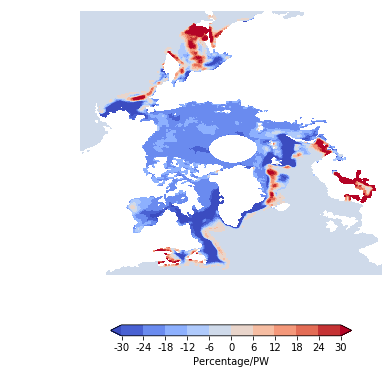

In [7]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********')
    print ('======================   AMET + 60N & SIC +winter (DJF)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_ERAI[:,:,213],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_season_series[:])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(sicpm[:-2,:,:,:],
                                                         span=lag_winter[lag], Dim_month=True)    
    stat_SIC_ERAI = meta.statistics.operator(SIC_season_series[:,:,:])
    stat_SIC_ERAI.anomaly(Dim_month=False)
    stat_SIC_ERAI.detrend()
    stat_SIC_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_SIC_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_ERAI._detrend,
                                                          stat_SIC_ERAI._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-30,30,11)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Percentage/PW'
    fig = plt.figure(figsize=(5.4,6.8))
    cs = plt.contourf(longitude_fields_sicpm, latitude_fields_sicpm, np.ma.masked_where(mask==1,k*100),
                      levels=ticks, cmap='coolwarm', extend='both')
    cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
                        shrink =0.8, pad=0.135, format='%d')
    cbar.set_label(label,size = 10)
    cbar.set_ticks(ticks)
    cbar.ax.tick_params(labelsize = 10)
    #plt.contour(longitude_fields_sicpm, latitude_fields_sicpm,p_real)
    #ii, jj = np.where(p_value<=0.05) # 95% significance
    #plt.plot(xaxis[jj], yaxis[ii], 'k.', alpha=0.4)
    plt.xlabel("xgrid")
    plt.ylabel("ygrid")
    plt.axis('off')
    #invert the y axis
    #plt.gca().invert_yaxis()
    plt.show()
    fig.savefig(os.path.join(output_path,'spatial_ERAI_AMET_60N_lag_{}_NOAA_SIC_DJF_interannual.png'.format(lag)),dpi=150)
    plt.close(fig)

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of MERRA2 !@#$%^&***********
======================   AMET + 60N & SIC +winter (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.


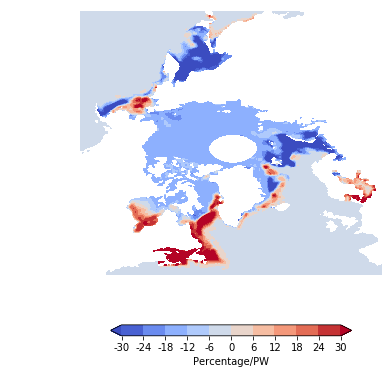

In [9]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of MERRA2 !@#$%^&***********')
    print ('======================   AMET + 60N & SIC +winter (DJF)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_MERRA2[:,:,300],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_MERRA2 = meta.statistics.operator(AMET_season_series[:])
    stat_AMET_MERRA2.anomaly(Dim_month=False)
    stat_AMET_MERRA2.detrend()
    stat_AMET_MERRA2.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(sicpm[1:-2,:,:,:],
                                                         span=lag_winter[lag], Dim_month=True)    
    stat_SIC_MERRA2 = meta.statistics.operator(SIC_season_series[:])
    stat_SIC_MERRA2.anomaly(Dim_month=False)
    stat_SIC_MERRA2.detrend()
    stat_SIC_MERRA2.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_MERRA2._lowpass,
                                                     stat_SIC_MERRA2._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_MERRA2._detrend,
                                                          stat_SIC_MERRA2._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-30,30,11)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Percentage/PW'
    fig = plt.figure(figsize=(5.4,6.8))
    cs = plt.contourf(longitude_fields_sicpm, latitude_fields_sicpm, np.ma.masked_where(mask==1,k*100),
                      levels=ticks, cmap='coolwarm', extend='both')
    cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
                        shrink =0.8, pad=0.135, format='%d')
    cbar.set_label(label,size = 10)
    cbar.set_ticks(ticks)
    cbar.ax.tick_params(labelsize = 10)
    #plt.contour(longitude_fields_sicpm, latitude_fields_sicpm,p_real)
    #ii, jj = np.where(p_value<=0.05) # 95% significance
    #plt.plot(xaxis[jj], yaxis[ii], 'k.', alpha=0.4)
    plt.xlabel("xgrid")
    plt.ylabel("ygrid")
    plt.axis('off')
    #invert the y axis
    #plt.gca().invert_yaxis()
    plt.show()
    fig.savefig(os.path.join(output_path,'spatial_MERRA2_AMET_60N_lag_{}_NOAA_SIC_DJF_interannual.png'.format(lag)),dpi=150)
    plt.close(fig)

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of JRA55 !@#$%^&***********
======================   AMET + 60N & SIC +winter (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.


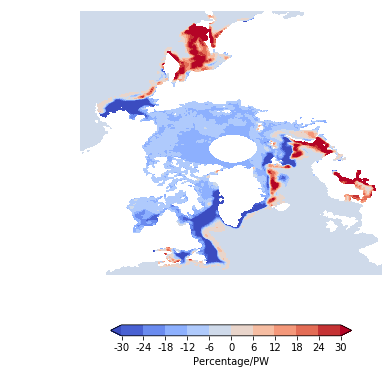

In [13]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of JRA55 !@#$%^&***********')
    print ('======================   AMET + 60N & SIC +winter (DJF)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_JRA55[:,:,267],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_JRA55 = meta.statistics.operator(AMET_season_series[:])
    stat_AMET_JRA55.anomaly(Dim_month=False)
    stat_AMET_JRA55.detrend()
    stat_AMET_JRA55.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(sicpm[:-5,:,:,:],
                                                         span=lag_winter[lag],Dim_month=True)
    stat_SIC_JRA55 = meta.statistics.operator(SIC_season_series[:])
    stat_SIC_JRA55.anomaly(Dim_month=False)
    stat_SIC_JRA55.detrend()
    stat_SIC_JRA55.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_JRA55._lowpass,
                                                     stat_SIC_JRA55._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_JRA55._detrend,
                                                          stat_SIC_JRA55._detrend)  
    ticks = np.linspace(-30,30,11)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Percentage/PW'
    fig = plt.figure(figsize=(5.4,6.8))
    cs = plt.contourf(longitude_fields_sicpm, latitude_fields_sicpm, np.ma.masked_where(mask==1,k*100),
                      levels=ticks, cmap='coolwarm', extend='both')
    cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
                        shrink =0.8, pad=0.135, format='%d')
    cbar.set_label(label,size = 10)
    cbar.set_ticks(ticks)
    cbar.ax.tick_params(labelsize = 10)
    #plt.contour(longitude_fields_sicpm, latitude_fields_sicpm,p_real)
    #ii, jj = np.where(p_value<=0.05) # 95% significance
    #plt.plot(xaxis[jj], yaxis[ii], 'k.', alpha=0.4)
    plt.xlabel("xgrid")
    plt.ylabel("ygrid")
    plt.axis('off')
    #invert the y axis
    #plt.gca().invert_yaxis()
    plt.show()
    fig.savefig(os.path.join(output_path,'spatial_JRA55_AMET_60N_lag_{}_NOAA_SIC_DJF_interannual.png'.format(lag)),dpi=150)
    plt.close(fig)

In [12]:
print(stat_AMET_JRA55._lowpass.shape)
print(stat_SIC_JRA55._lowpass.shape)

(91,)
(94, 448, 304)


Be cautious about the time across the year! The definition of sign is a bit different from others. Negative means the climatology leads.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********
======================   AMET + 60N & SIC + summer (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.


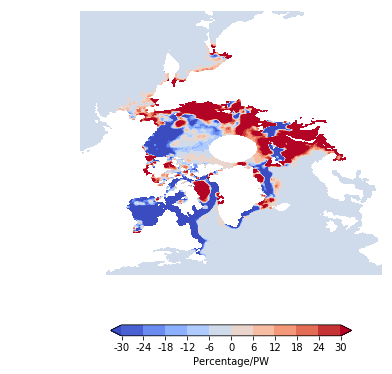

In [15]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********')
    print ('======================   AMET + 60N & SIC + summer (DJF)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_ERAI[:,:,213],
                                                          span='JJA', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_season_series[:])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(sicpm[:-2,:,:,:],
                                                         span=lag_summer[lag], Dim_month=True)    
    stat_SIC_ERAI = meta.statistics.operator(SIC_season_series[:])
    stat_SIC_ERAI.anomaly(Dim_month=False)
    stat_SIC_ERAI.detrend()
    stat_SIC_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_SIC_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_ERAI._detrend,
                                                          stat_SIC_ERAI._detrend)  
    ticks = np.linspace(-30,30,11)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Percentage/PW'
    fig = plt.figure(figsize=(5.4,6.8))
    cs = plt.contourf(longitude_fields_sicpm, latitude_fields_sicpm, np.ma.masked_where(mask==1,k*100),
                      levels=ticks, cmap='coolwarm', extend='both')
    cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
                        shrink =0.8, pad=0.135, format='%d')
    cbar.set_label(label,size = 10)
    cbar.set_ticks(ticks)
    cbar.ax.tick_params(labelsize = 10)
    #plt.contour(longitude_fields_sicpm, latitude_fields_sicpm,p_real)
    #ii, jj = np.where(p_value<=0.05) # 95% significance
    #plt.plot(xaxis[jj], yaxis[ii], 'k.', alpha=0.4)
    plt.xlabel("xgrid")
    plt.ylabel("ygrid")
    plt.axis('off')
    #invert the y axis
    #plt.gca().invert_yaxis()
    plt.show()
    fig.savefig(os.path.join(output_path,'spatial_ERAI_AMET_60N_lag_{}_NOAA_SIC_JJA_interannual.png'.format(lag)),dpi=150)
    plt.close(fig)

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of MERRA2 !@#$%^&***********
======================   AMET + 60N & SIC + summer (JJA)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.


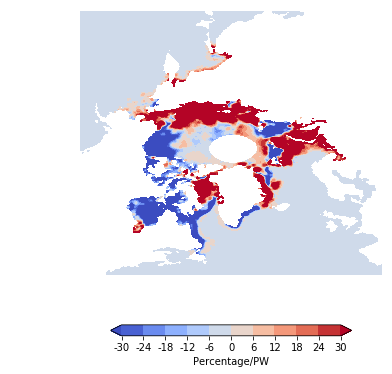

In [17]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of MERRA2 !@#$%^&***********')
    print ('======================   AMET + 60N & SIC + summer (JJA)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_MERRA2[:,:,300],
                                                          span='JJA', Dim_month=True)    
    stat_AMET_MERRA2 = meta.statistics.operator(AMET_season_series[:])
    stat_AMET_MERRA2.anomaly(Dim_month=False)
    stat_AMET_MERRA2.detrend()
    stat_AMET_MERRA2.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(sicpm[1:-2,:,:,:],
                                                         span=lag_summer[lag], Dim_month=True)    
    stat_SIC_MERRA2 = meta.statistics.operator(SIC_season_series[:])
    stat_SIC_MERRA2.anomaly(Dim_month=False)
    stat_SIC_MERRA2.detrend()
    stat_SIC_MERRA2.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_MERRA2._lowpass,
                                                     stat_SIC_MERRA2._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_MERRA2._detrend,
                                                          stat_SIC_MERRA2._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-30,30,11)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Percentage/PW'
    fig = plt.figure(figsize=(5.4,6.8))
    cs = plt.contourf(longitude_fields_sicpm, latitude_fields_sicpm, np.ma.masked_where(mask==1,k*100),
                      levels=ticks, cmap='coolwarm', extend='both')
    cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
                        shrink =0.8, pad=0.135, format='%d')
    cbar.set_label(label,size = 10)
    cbar.set_ticks(ticks)
    cbar.ax.tick_params(labelsize = 10)
    #plt.contour(longitude_fields_sicpm, latitude_fields_sicpm,p_real)
    #ii, jj = np.where(p_value<=0.05) # 95% significance
    #plt.plot(xaxis[jj], yaxis[ii], 'k.', alpha=0.4)
    plt.xlabel("xgrid")
    plt.ylabel("ygrid")
    plt.axis('off')
    #invert the y axis
    #plt.gca().invert_yaxis()
    plt.show()
    fig.savefig(os.path.join(output_path,'spatial_MERRA2_AMET_60N_lag_{}_NOAA_SIC_JJA_interannual.png'.format(lag)),dpi=150)
    plt.close(fig)

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of JRA55 !@#$%^&***********
======================   AMET + 60N & SIC + summer (JJA)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.


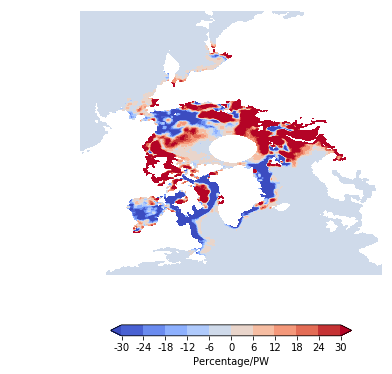

In [14]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of JRA55 !@#$%^&***********')
    print ('======================   AMET + 60N & SIC + summer (JJA)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_JRA55[:,:,267],
                                                          span='JJA', Dim_month=True)    
    stat_AMET_JRA55 = meta.statistics.operator(AMET_season_series[:])
    stat_AMET_JRA55.anomaly(Dim_month=False)
    stat_AMET_JRA55.detrend()
    stat_AMET_JRA55.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(sicpm[:-5,:,:,:],
                                                         span=lag_summer[lag],Dim_month=True)
    stat_SIC_JRA55 = meta.statistics.operator(SIC_season_series[:])
    stat_SIC_JRA55.anomaly(Dim_month=False)
    stat_SIC_JRA55.detrend()
    stat_SIC_JRA55.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_JRA55._lowpass,
                                                     stat_SIC_JRA55._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_JRA55._detrend,
                                                          stat_SIC_JRA55._detrend)  
    ticks = np.linspace(-30,30,11)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Percentage/PW'
    fig = plt.figure(figsize=(5.4,6.8))
    cs = plt.contourf(longitude_fields_sicpm, latitude_fields_sicpm, np.ma.masked_where(mask==1,k*100),
                      levels=ticks, cmap='coolwarm', extend='both')
    cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
                        shrink =0.8, pad=0.135, format='%d')
    cbar.set_label(label,size = 10)
    cbar.set_ticks(ticks)
    cbar.ax.tick_params(labelsize = 10)
    #plt.contour(longitude_fields_sicpm, latitude_fields_sicpm,p_real)
    #ii, jj = np.where(p_value<=0.05) # 95% significance
    #plt.plot(xaxis[jj], yaxis[ii], 'k.', alpha=0.4)
    plt.xlabel("xgrid")
    plt.ylabel("ygrid")
    plt.axis('off')
    #invert the y axis
    #plt.gca().invert_yaxis()
    plt.show()
    fig.savefig(os.path.join(output_path,'spatial_JRA55_AMET_60N_lag_{}_NOAA_SIC_JJA_interannual.png'.format(lag)),dpi=150)
    plt.close(fig)